<a href="https://www.kaggle.com/code/aarnbernal/sign-language-mnist?scriptVersionId=235300976" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
datamunge_sign_language_mnist_path = kagglehub.dataset_download('datamunge/sign-language-mnist')

print('Data source import complete.')

Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):                                        # SOLO PARA KAGGLE
#for dirname, _, filenames in os.walk(datamunge_sign_language_mnist_path):                      # no kaggle
    for filename in filenames:
        print(os.path.join(dirname, filename))

n_jobs = -1 # number of jobs to run in parallel
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


Cargo los datos y los separo en desarrollo y evaluación final

In [3]:
data_eval = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')
data_dev = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv').sample(frac=1, random_state=28)
X_eval, y_eval = data_eval.iloc[:, 1:], data_eval.iloc[:, 0]
X_dev, y_dev = data_dev.iloc[:, 1:], data_dev.iloc[:, 0]
X_dev.head(3)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
13555,189,193,196,201,205,209,211,212,213,214,...,81,70,66,64,64,59,53,55,62,48
3670,111,118,125,129,136,141,143,144,148,151,...,8,142,229,219,220,221,221,221,221,221
1347,169,172,175,178,180,183,184,185,187,189,...,218,217,216,215,213,212,211,210,208,207


In [4]:
y_dev.head(3)

13555     7
3670     16
1347      7
Name: label, dtype: int64

## Exploración

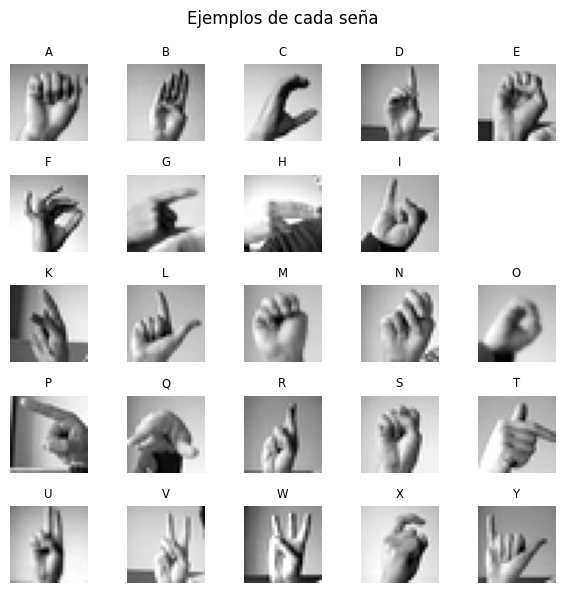

In [5]:
# funcion auxiliar
def graficar_fila(row, ax, label=None):
    n = int(np.sqrt(len(row)))
    ax.imshow(row.values.reshape(n, n), cmap='gray')
    if label is not None:
        ax.set_title(label, fontsize='small')
    ax.axis('off')

leters = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(6, 6))
for i, ax in enumerate(axs.flat):
    X_dev_i = X_dev[y_dev == i]
    if X_dev_i.shape[0] > 0:
        graficar_fila(X_dev_i.iloc[0], ax=ax, label=leters[i])
    else:
        ax.axis('off')
fig.suptitle('Ejemplos de cada seña')
fig.tight_layout()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


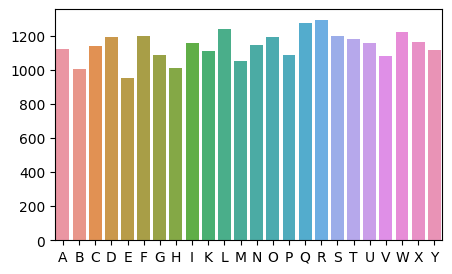

In [6]:
# proporcion de cada letra en el dataset de desarrollo
count = y_dev.value_counts().sort_index()
plt.figure(figsize=(5, 3))
sns.barplot(x=[leters.get(i, '?') for i in count.index], y=count.values)
plt.show()

Los datos estan balanceados, no hay necesidad de hacer stratified sampling.

In [7]:
if X_dev.shape[0] == X_dev.value_counts().shape[0]: # no hay duplicados en el dataset de desarrollo
    print('No hay duplicados en el dataset de desarrollo')
else:
    print('Hay duplicados en el dataset de desarrollo, limpiar el dataset para evitar filtacion de datos')

No hay duplicados en el dataset de desarrollo


## Un modelo simple
Arbol de profundidad maxima 10

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_dev_train, X_dev_test, y_dev_train, y_dev_test = train_test_split(X_dev, y_dev, test_size=0.3, random_state=28)
tree = DecisionTreeClassifier(max_depth=10, random_state=28)
tree.fit(X_dev_train, y_dev_train)
y_dev_pred = tree.predict(X_dev_test)

print('Accuracy con test: ', accuracy_score(y_dev_test, y_dev_pred))

Accuracy con test:  0.5805511715430375


Veamos donde caen las features (pixeles) mas importantes para este modelo, ello veamos como se distribuyen. Esto nos dara un cota inferior razonable.

Text(0.5, 1.0, 'Importancia de los pixels')

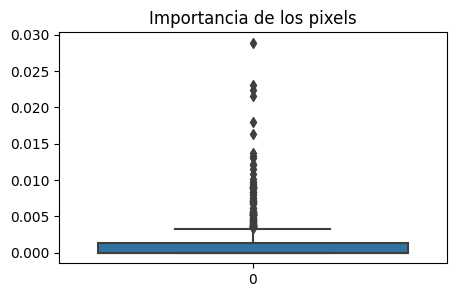

In [9]:
plt.figure(figsize=(5, 3))
sns.boxplot(tree.feature_importances_)
plt.title('Importancia de los pixels')

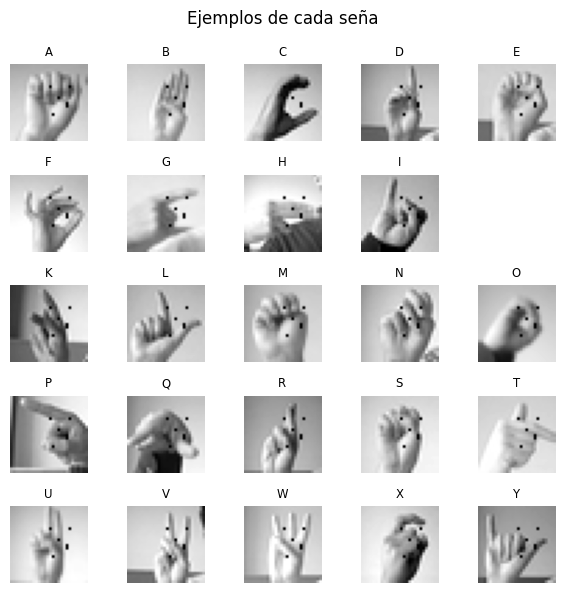

In [10]:
pixeles_mas_importantes = X_dev.columns[tree.feature_importances_ > 0.015] # cota elegida a ojo

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(6, 6))
for i, ax in enumerate(axs.flat):
    X_dev_i = X_dev[y_dev == i]
    if X_dev_i.shape[0] > 0:
        row = X_dev_i.iloc[0]
        row[pixeles_mas_importantes] = 0 # en negro
        graficar_fila(row, ax=ax, label=leters[i])
    else:
        ax.axis('off')
fig.suptitle('Ejemplos de cada seña')
fig.tight_layout()

Se observa que la mayoría de ellos se ubican sobre los dedos y contornos de la mano, lo que indica que el modelo está aprendiendo patrones coherentes con las diferencias morfológicas entre las clases. En algunos casos, como en las letras "C" o "L", los píxeles relevantes están claramente alineados con la forma característica del gesto, lo que refuerza la interpretación de que el modelo está focalizando en información útil.

### Validacion cruzada con 5 folds

In [11]:
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1_macro',
    'roc_auc': 'roc_auc_ovr'
}

scores = cross_validate(DecisionTreeClassifier(max_depth=10), X_dev_test, y_dev_test, cv=5, scoring=scoring, n_jobs=n_jobs)

print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_roc_auc'])


In [12]:
# Calculating mean scores for each metric
accuracy_scores = scores['test_accuracy']
auprc_scores = scores['test_f1']
roc_auc_scores = scores['test_roc_auc']

mean_accuracy = np.mean(accuracy_scores)
mean_auprc = np.mean(auprc_scores)
mean_roc_auc = np.mean(roc_auc_scores)

# Creating a DataFrame for scores
scores_df = pd.DataFrame({
    'Fold': range(1, len(accuracy_scores) + 1),
    'Accuracy': accuracy_scores,
    'f1 macro': auprc_scores,
    'ROC AUC OneVSRest': roc_auc_scores
})

# Adding the mean row
mean_row = pd.DataFrame({
    'Fold': ['Mean'],
    'Accuracy': [mean_accuracy],
    'f1 macro': [mean_auprc],
    'ROC AUC OneVSRest': [mean_roc_auc]
})
scores_df = pd.concat([scores_df, mean_row], ignore_index=True)

# Displaying the table
print(scores_df)

   Fold  Accuracy  f1 macro  ROC AUC OneVSRest
0     1  0.541869  0.548066           0.885498
1     2  0.515170  0.517707           0.867339
2     3  0.536126  0.545579           0.886626
3     4  0.508197  0.531623           0.871230
4     5  0.523376  0.535072           0.879910
5  Mean  0.524948  0.535609           0.878121


Los resultados muestran que el modelo tiene un desempeño bastante flojo: la accuracy ronda el 50% y F1 macro, también cercano al 0.53, indica que el modelo no está equilibrando bien precisión y recall entre las clases. Aunque el ROC AUC por clase está un poco mejor (~0.85). En general, parece que el modelo no distingue bien entre las clases.

## Comparacion de algoritmos

Realizamos RandomizedSearchCV con Arboles de decision, KNN y SVM. Usamos como metrica de performance accuracy ya que tenemo un dataset balanceado (por lo menos los de desarrollo). Vale la pena aclarar que accuracy es de las peor metricas para evaluar un modelo, pero no existe un consenso una metrica integral para el clasificacion multiclase, además es la metrica que usa kaggle.

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

tree_param_grid = {
    'max_depth': range(1,90), 'criterion': ['gini', 'entropy'],
    'random_state':[28]
}

knn_param_grid = {
    'n_neighbors': range(1,50)
}

svm_param_grid = {
    'C': np.logspace(-4, 2, 20),
    'random_state':[28]
}

rscv_tree = RandomizedSearchCV(DecisionTreeClassifier(), tree_param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=n_jobs, random_state=28)
rscv_knn = RandomizedSearchCV(KNeighborsClassifier(), knn_param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=n_jobs, random_state=28)
rscv_svm = RandomizedSearchCV(SVC(), svm_param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=n_jobs, random_state=28)

rscv_tree.fit(X_dev_train, y_dev_train)
print('Mejores hiperparametros para arbol de decision: ', rscv_tree.best_params_)
print('         Accuracy: ', rscv_tree.best_score_)
print()

rscv_knn.fit(X_dev_train, y_dev_train)
print('Mejores hiperparametros para KNN: ', rscv_knn.best_params_)
print('         Accuracy: ', rscv_knn.best_score_)
print()

rscv_svm.fit(X_dev_train, y_dev_train)
print('Mejores hiperparametros para SVM: ', rscv_svm.best_params_)
print('         Accuracy: ', rscv_svm.best_score_)

Mejores hiperparametros para arbol de decision:  {'random_state': 28, 'max_depth': 65, 'criterion': 'entropy'}
         Accuracy:  0.8633572182675747

Mejores hiperparametros para KNN:  {'n_neighbors': 10}
         Accuracy:  0.9785619108813869

Mejores hiperparametros para SVM:  {'random_state': 28, 'C': 100.0}
         Accuracy:  0.9998959417273673


Veamos que tal LDA y Naive Bayes

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import naive_bayes

scores_LDA = cross_val_score(LinearDiscriminantAnalysis(), X_dev_train, y_dev_train, cv=4, n_jobs=n_jobs, scoring='accuracy')
print('Cross validation scores for LDA:', scores_LDA)
print('         Mean:', scores_LDA.mean())
print()

for func in [naive_bayes.GaussianNB, naive_bayes.MultinomialNB]:
    scores = cross_val_score(func(), X_dev_train, y_dev_train, cv=4, n_jobs=n_jobs, scoring='accuracy')
    print(f'Cross validation scores for {func.__name__}:', scores)
    print('            Mean:', scores.mean())
    print()

scores_RF = cross_val_score(RandomForestClassifier(random_state=28), X_dev_train, y_dev_train, cv=4, n_jobs=n_jobs, scoring='accuracy')
print('Cross validation scores for RandomForest:', scores_RF)
print('         Mean:', scores_RF.mean())
print()


Cross validation scores for LDA: [0.98668054 0.98189386 0.98563697 0.98834305]
         Mean: 0.9856386045794304

Cross validation scores for GaussianNB: [0.43808533 0.46347555 0.45024979 0.46003331]
            Mean: 0.4529609928770769

Cross validation scores for MultinomialNB: [0.52715921 0.54484912 0.52268943 0.53830142]
            Mean: 0.5332497914069181

Cross validation scores for RandomForest: [0.99458897 0.99229969 0.9927144  0.99354704]
         Mean: 0.9932875266102389



## Sesgo y varianza

Estudiaremos mas a fondo el mejor arbol, Random Forest, SVM y Linear discriminant analysis (LDA)

### Curvas de complejidad

In [15]:
def curva(model, X_train, X_test, y_train, y_test, param :str, steps):
    sub_train_error = []
    test_error = []
    for i in steps:
        model2 = model(**{param: i, 'random_state': 28})
        model2.fit(X_train, y_train)
        sub_train_error.append(1 - accuracy_score(y_train, model2.predict(X_train)))
        test_error.append(1 - accuracy_score(y_test, model2.predict(X_test)))
    return sub_train_error, test_error

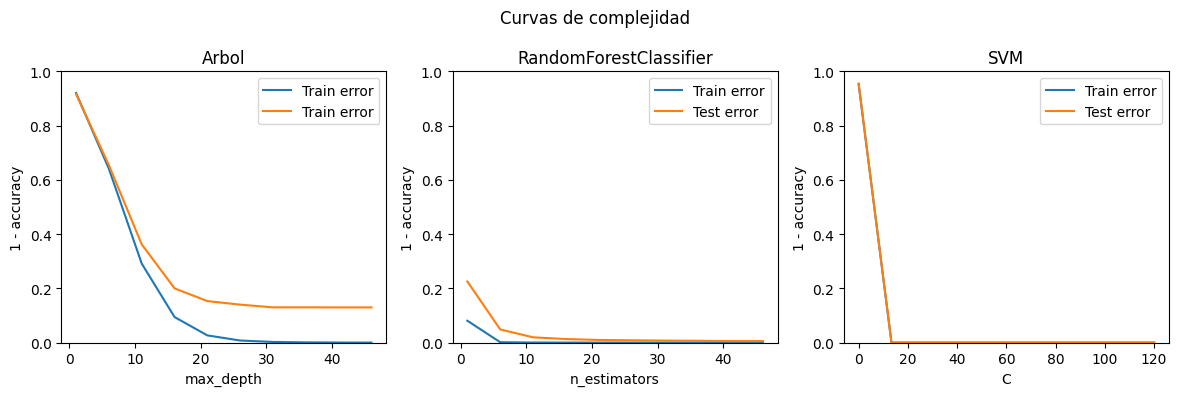

In [16]:
plt.figure(figsize=(12, 4))

cant = 10
max_complex = 50
steps = np.arange(1, max_complex, max_complex//cant, dtype=int)
y_1, y_2 = curva(DecisionTreeClassifier, X_dev_train, X_dev_test, y_dev_train, y_dev_test, 'max_depth', steps)

plt.subplot(1,3,1)
plt.plot(steps, y_1, label="Train error")
plt.plot(steps, y_2, label="Train error")
plt.title("Arbol")
plt.xlabel("max_depth")
plt.ylabel("1 - accuracy")
plt.ylim((0,1))
plt.legend()

y_1, y_2 = curva(RandomForestClassifier, X_dev_train, X_dev_test, y_dev_train, y_dev_test, 'n_estimators', steps)

plt.subplot(1,3,2)
plt.plot(steps, y_1, label="Train error")
plt.plot(steps, y_2, label="Test error")
plt.title("RandomForestClassifier")
plt.xlabel("n_estimators")
plt.ylabel("1 - accuracy")
plt.ylim((0,1))
plt.legend()

steps = np.linspace(1e-4, 120, cant)
y_1, y_2 = curva(SVC, X_dev_train, X_dev_test, y_dev_train, y_dev_test, 'C', steps)

plt.subplot(1,3,3)
plt.plot(steps, y_1, label="Train error")
plt.plot(steps, y_2, label="Test error")
plt.title("SVM")
plt.xlabel("C")
plt.ylabel("1 - accuracy")
plt.ylim((0,1))
plt.legend()

plt.suptitle('Curvas de complejidad')
plt.tight_layout()
plt.show()

Estas curvas de complejidad muestran cómo varía el error (medido como \(1 - accuracy)) en el conjunto de entrenamiento y test a medida que se incrementa la complejidad del modelo, según un hiperparámetro característico:

- **Árbol de Decisión:** Se observa una clara mejora en el desempeño al aumentar `max_depth` hasta cierto punto, donde ambos errores convergen, esto sugiere que el modelo ha alcanzado un punto de sobreajuste.
- **Random Forest:** A medida que se incrementa el número de árboles (`n_estimators`), el error disminuye rápidamente, estabilizándose con un rendimiento sólido tanto en entrenamiento como en test.
- **SVM:** El parámetro `C` controla la penalización por errores de clasificación. Para valores bajos, el modelo subajusta fuertemente (altos errores). A partir de \(C $\sim$ 0.2\), el modelo logra ajustar correctamente, alcanzando un mínimo error de generalización.

Estas curvas no solo permiten comparar modelos, sino también entender el comportamiento de cada uno frente a la complejidad y cómo responden al ajuste de hiperparámetros clave.

### Curvas de aprendizaje

In [17]:
from copy import deepcopy

def curva_de_aprendizaje(model, X_train, X_test, y_train, y_test):
    sub_train_error = []
    test_error = []
    for i in np.linspace(800, len(X_dev_train), 8, dtype=int):
        X_train_i = X_train.iloc[:i,:]
        y_train_i = y_train.iloc[:i]
        X_test_i  =  X_test.iloc[:i,:]
        y_test_i  =  y_test.iloc[:i]
        model2 = deepcopy(model)
        model2.fit(X_train_i, y_train_i)
        sub_train_error.append(1 - accuracy_score(y_train_i, model2.predict(X_train_i)))
        test_error.append(1 - accuracy_score(y_test_i, model2.predict(X_test_i)))
    return sub_train_error, test_error

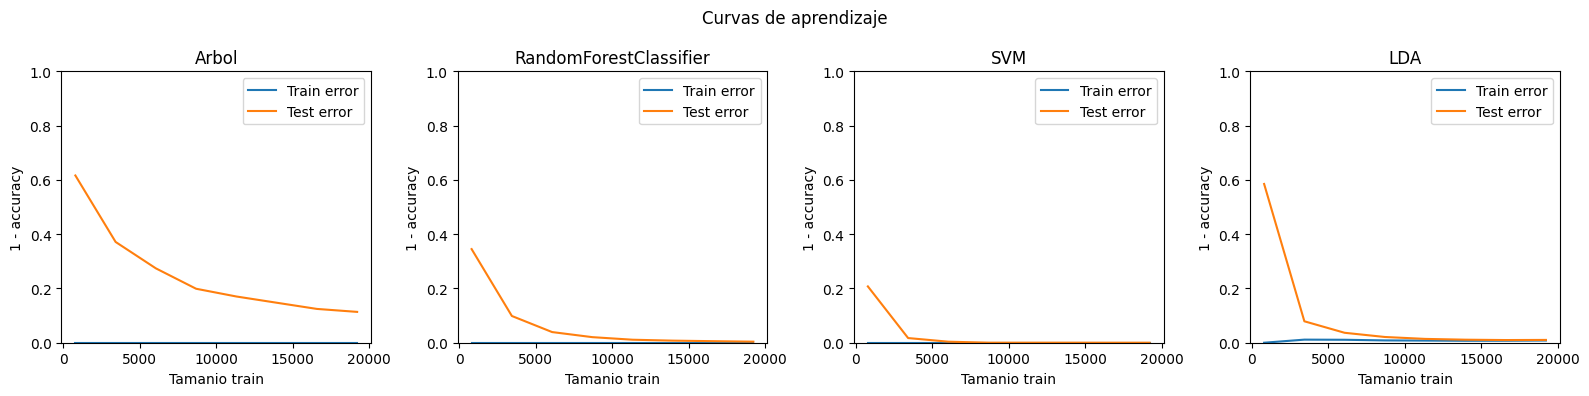

In [18]:
x = np.linspace(800, len(X_dev_train), 8)
plt.figure(figsize=(16, 4))

y_1, y_2 = curva_de_aprendizaje(DecisionTreeClassifier(**rscv_tree.best_params_), X_dev_train, X_dev_test, y_dev_train, y_dev_test)

plt.subplot(1,4,1)
plt.plot(x, y_1, label="Train error")
plt.plot(x, y_2, label="Test error")
plt.title("Arbol")
plt.xlabel("Tamanio train")
plt.ylabel("1 - accuracy")
plt.ylim((0,1))
plt.legend()

y_1, y_2 = curva_de_aprendizaje(RandomForestClassifier(random_state=28), X_dev_train, X_dev_test, y_dev_train, y_dev_test)

plt.subplot(1,4,2)
plt.plot(x, y_1, label="Train error")
plt.plot(x, y_2, label="Test error")
plt.title("RandomForestClassifier")
plt.xlabel("Tamanio train")
plt.ylabel("1 - accuracy")
plt.ylim((0,1))
plt.legend()

y_1, y_2 = curva_de_aprendizaje(SVC(**rscv_svm.best_params_), X_dev_train, X_dev_test, y_dev_train, y_dev_test)

plt.subplot(1,4,3)
plt.plot(x, y_1, label="Train error")
plt.plot(x, y_2, label="Test error")
plt.title("SVM")
plt.xlabel("Tamanio train")
plt.ylabel("1 - accuracy")
plt.ylim((0,1))
plt.legend()

y_1, y_2 = curva_de_aprendizaje(LinearDiscriminantAnalysis(), X_dev_train, X_dev_test, y_dev_train, y_dev_test)

plt.subplot(1,4,4)
plt.plot(x, y_1, label="Train error")
plt.plot(x, y_2, label="Test error")
plt.title("LDA")
plt.xlabel("Tamanio train")
plt.ylabel("1 - accuracy")
plt.ylim((0,1))
plt.legend()

plt.suptitle('Curvas de aprendizaje')
plt.tight_layout()
plt.show()

Las curvas de aprendizaje permiten analizar el comportamiento del error a medida que se incrementa el tamaño del conjunto de entrenamiento. Se presentan las curvas para cuatro modelos: Árbol de Decisión, Random Forest, SVM y LDA. En el eje \(x\) se muestra el tamaño del conjunto de entrenamiento, y en el eje \(y\), el error (1 - accuracy) para entrenamiento y test.

- **Árbol de Decisión:** El error de entrenamiento se mantiene cercano a cero, mientras que el error de test disminuye progresivamente con más datos. Esto sugiere un modelo con baja varianza pero cierto sesgo.
- **Random Forest:** Se logra un excelente desempeño con mas de una cuarta parte de los datos. El error de test converge rápidamente a un valor muy bajo, indicando robustez y buena generalización.
- **SVM:** También muestra una rápida convergencia del error de test, confirmando su capacidad de generalizar bien, probablemente gracias a la separación que logra el kernel gaussiano.
- **LDA:** Presenta un comportamiento similar a SVM, aunque su rendimiento es levemente inferior. Su naturaleza lineal parece ser suficiente para capturar bien la estructura de los datos en este caso.

En todos los casos, la brecha entre los errores de entrenamiento y test se reduce con mayor cantidad de datos, lo cual es un buen indicio de que los modelos no están sobreajustando. Además, se evidencia que más datos contribuyen a una mejora en la generalización.

A medida que aumenta el tamaño del conjunto de entrenamiento, la diferencia entre el error de entrenamiento y el de test tiende a reducirse, lo cual sugiere que los modelos están logrando una buena capacidad de generalización. En general, se observa que disponer de más datos tiene un efecto positivo en el desempeño de los modelos sobre datos no vistos, sin embargo, requiere tiempo considerable de ejecución.


## Evaluacion de performance

Elijo SVM como modelo final, ya que es el que mejor desempeño tiene en el conjunto de test. Aun así, la diferencia con Random Forest no es significativa.

In [19]:
best = SVC(**rscv_svm.best_params_)
best.fit(X_dev, y_dev)
y_pred = best.predict(X_eval)

print('Accuracy con los datos de evaluacion: ', accuracy_score(y_eval, y_pred))

Accuracy con los datos de evaluacion:  0.8367261572783046


El modelo SVM ajustado con los mejores hiperparámetros alcanzó una accuracy del 83.67% en el conjunto de evaluación.

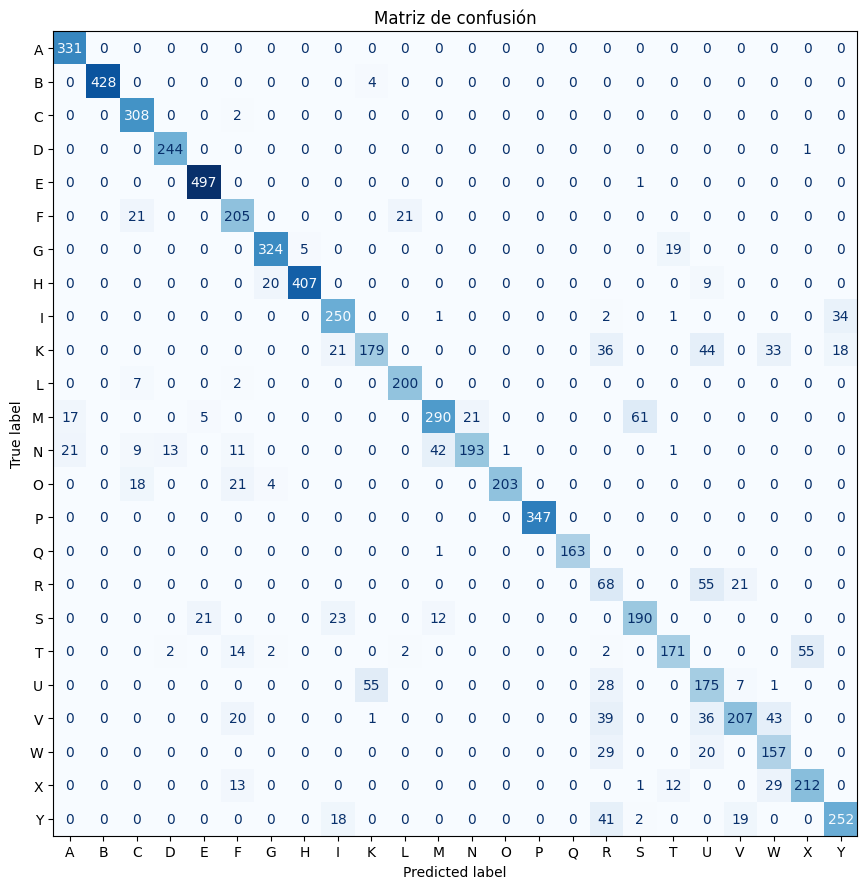

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(9, 9))
ConfusionMatrixDisplay.from_predictions(
    y_eval, y_pred, display_labels=[leters[i] for i in leters.keys()],
    ax=ax, cmap='Blues', colorbar=False
)

plt.title('Matriz de confusión')

plt.tight_layout()
plt.show()

La matriz de confusión muestra que el modelo SVM tiene un buen desempeño general en la clasificación de la mayoría de las letras. Sin embargo, se observan algunos errores frecuentes, por ejemplo entre U, V y W, posiblemente por similitudes estructurales.

A pesar de estas confusiones, el modelo parece capturar bien la mayoría de las clases, lo cual es consistente con la accuracy del 83.67% obtenida en la evaluación. Para mejorar aún más, se podría probar un `RandomizedSearchCV` más abarcativo (con el suficiente poder de cómputo) o modelos más complejos (e.g., CNN).